### 1. Descomprimimos el Dataset

In [19]:
# Dirección de los archivos del dataset
dataset_path = "C:/Users/USER/Documents/Datasets/archive/C2A_Dataset/new_dataset3"

In [4]:
import zipfile

zip_path = "C:/Users/USER/Documents/Datasets/archive.zip"
extract_path = "C:/Users/USER/Documents/Datasets/archive"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

### 2. Distribución del Tamaño de los Objetos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# Distribución de tamaños de los objetos en el dataset
def get_object_sizes(label_dir):
  sizes = []
  for label_file in tqdm(os.listdir(label_dir)[:6129]):  # Muestra parcial para acelerar procesamiento
    with open(os.path.join(label_dir, label_file), 'r') as f:
      for line in f:
        _, _, _, w, h = map(float, line.strip().split())  # Extraer ancho y alto del objeto
        sizes.append(w * h)  # Calcular el área del objeto
  return sizes

# Obtener tamaños de los objetos en el conjunto de entrenamiento
sizes = get_object_sizes(f"{dataset_path}/train/labels")

# Umbral dinámico para definir objetos pequeños (percentil 25)
small_threshold = np.percentile(sizes, 25)

# Gráfica de distribución de áreas de objetos
plt.figure(figsize=(10, 5))
plt.hist(sizes, bins=50, alpha=0.7, label='Distribución de objetos')
plt.axvline(small_threshold, color='r', linestyle='--', label=f'Umbral de objeto pequeño ({small_threshold:.4f})')
plt.title("Distribución del Área de los Objetos Normalizada")
plt.xlabel("Área del objeto (normalizado)")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

100%|██████████| 6129/6129 [00:00<00:00, 8883.56it/s]


<Figure size 1000x500 with 1 Axes>

### 3. Iterar a través de los labels de cada archivo

100%|██████████| 1000/1000 [00:04<00:00, 208.12it/s]


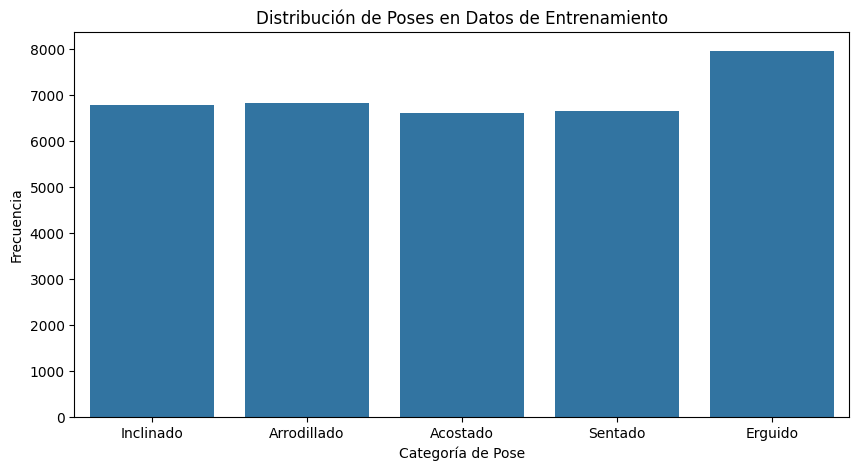

In [7]:
import seaborn as sns

# Conteo de poses en el dataset
pose_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}  # 0: Inclinado, 1: Arrodillado, 2: Acostado, 3: Sentado, 4: Erguido

# Iterar sobre los archivos de etiquetas
label_dir = f"{dataset_path}/All labels with Pose information/labels"
for pose_file in tqdm(os.listdir(label_dir)[:1000]):  # Procesar una muestra para mejorar rendimiento
  file_path = os.path.join(label_dir, pose_file)
  with open(file_path, 'r') as f:
    for line in f:  # Leer todas las líneas del archivo
      parts = line.strip().split()
      if len(parts) > 5:  # Verificar si existe un ID de pose
        try:
          pose_id = int(parts[5])  # Extraer el ID de pose
          if pose_id in pose_counts:  # Asegurar que el ID es válido
            pose_counts[pose_id] += 1
        except (ValueError, IndexError):
          continue  # Omitir entradas inválidas

# Graficar la distribución de poses
plt.figure(figsize=(10, 5))
sns.barplot(x=list(pose_counts.keys()), y=list(pose_counts.values()))

# Actualizar etiquetas de los ejes
plt.xticks([0, 1, 2, 3, 4], ['Inclinado', 'Arrodillado', 'Acostado', 'Sentado', 'Erguido'])
plt.title("Distribución de Poses en Datos de Entrenamiento")
plt.xlabel("Categoría de Pose")
plt.ylabel("Frecuencia")
plt.show()

Crea la carpeta `working` en `C:\Users\Chris\Documents\Datasets\archive\C2A_Dataset\new_dataset3`

In [21]:
import yaml

# Configuración base del dataset C2A para entrenamiento con YOLO
base_yaml = {
  "path": dataset_path,  # Ruta raíz del dataset
  "train": f"{dataset_path}/train/images",  # Carpeta de imágenes de entrenamiento
  "val": f"{dataset_path}/val/images",  # Carpeta de imágenes de validación
  "names": {0: "Human"},  # Clases en el dataset (solo una: 'Human')
  "nc": 1,  # Número de clases en el dataset
  "augment": True  # Aplicación de aumentos de datos para mejorar la generalización
}

# Guardar la configuración en un archivo YAML
with open(f"{dataset_path}/working/c2a.yaml", "w") as f:
  yaml.dump(base_yaml, f)

In [22]:
with open(f"{dataset_path}/working/c2a.yaml", "r") as f:
  print(f.read())

augment: true
names:
  0: Human
nc: 1
path: C:/Users/USER/Documents/Datasets/archive/C2A_Dataset/new_dataset3
train: C:/Users/USER/Documents/Datasets/archive/C2A_Dataset/new_dataset3/train/images
val: C:/Users/USER/Documents/Datasets/archive/C2A_Dataset/new_dataset3/val/images



In [28]:
# Configuración para identificar objetos pequeños con un umbral dinámico
small_images = []

# Iterar sobre los archivos de etiquetas en el conjunto de entrenamiento
for label_file in tqdm(os.listdir(f"{dataset_path}/train/labels")[:3000]):  # Muestra parcial para eficiencia (6129/6129)
  with open(os.path.join(f"{dataset_path}/train/labels", label_file), 'r') as f:
    # Verificar si algún objeto en el archivo tiene un área menor al umbral definido
    if any(float(line.split()[3]) * float(line.split()[4]) < small_threshold for line in f):
      small_images.append(f"{dataset_path}/train/images/{label_file.replace('.txt', '.png')}")

# Guardar la lista de imágenes con objetos pequeños en un archivo de texto
with open(f"{dataset_path}/working/train_small.txt", "w") as f:
  f.write("\n".join(small_images))

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:00<00:00, 8005.05it/s]


In [29]:
import shutil
import os

# Ruta al archivo .txt con las rutas de las imágenes
txt_file = f'{dataset_path}/working/train_small.txt'

# Carpeta destino donde se copiarán las imágenes
destination_folder = f'{dataset_path}/train_small/images'

# Crear la carpeta destino si no existe
os.makedirs(destination_folder, exist_ok=True)

# Leer las rutas desde el archivo .txt
with open(txt_file, 'r') as file:
  image_paths = [line.strip() for line in file if line.strip()]

# Copiar las imágenes
for path in image_paths:
  if os.path.exists(path):
    filename = os.path.basename(path)
    dest_path = os.path.join(destination_folder, filename)
    shutil.copy2(path, dest_path)
  else:
    print(f'❌ Imagen no encontrada: {path}')

print(f'✅ Proceso terminado. Total de imágenes copiadas: {len(image_paths)}')

✅ Proceso terminado. Total de imágenes copiadas: 2468


In [30]:
import yaml

# Configuración para entrenamiento con objetos pequeños en el dataset C2A
small_yaml = {
    "path": dataset_path,  # Ruta raíz del dataset
    "train": f"{dataset_path}/train_small/images",  # Lista de imágenes con objetos pequeños
    "val": f"{dataset_path}/val/images",  # Carpeta de imágenes de validación
    "names": {0: "Human"},  # Clases en el dataset (solo una: 'Human')
    "nc": 1,  # Número de clases en el dataset
    "augment": True,  # Activar aumentos de datos para mejorar la generalización
    "mosaic": 1.0  # Aumento con técnica de mosaico para mejorar la detección de objetos pequeños
}

# Guardar la configuración en un archivo YAML
with open(f"{dataset_path}/working/c2a_small.yaml", "w") as f:
    yaml.dump(small_yaml, f)

In [31]:
with open(f"{dataset_path}/working/c2a_small.yaml", "r") as f:
  print(f.read())

augment: true
mosaic: 1.0
names:
  0: Human
nc: 1
path: C:/Users/USER/Documents/Datasets/archive/C2A_Dataset/new_dataset3
train: C:/Users/USER/Documents/Datasets/archive/C2A_Dataset/new_dataset3/train_small/images
val: C:/Users/USER/Documents/Datasets/archive/C2A_Dataset/new_dataset3/val/images



In [32]:
from glob import glob

images = glob('C:/Users/USER/Documents/Datasets/archive/C2A_Dataset/new_dataset3/train_small/images/*.png')
print(f"Imágenes encontradas: {len(images)}")

Imágenes encontradas: 2468


In [33]:
from ultralytics import YOLO

# Cargar modelo preentrenado YOLOv8n (puede ser 'yolov9e', 'yolov9c', etc.)
model = YOLO('yolov9e.pt')

# Entrenar con los datos personalizados
results = model.train(
    data=f'{dataset_path}/working/c2a_small.yaml',
    epochs=25,
    imgsz=640,
    batch=8,
    project="/working",
    name='rafaBot_pose_detector1',
    exist_ok=True
)

100%|██████████| 112M/112M [05:30<00:00, 356kB/s]  


New https://pypi.org/project/ultralytics/8.3.152 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.151  Python-3.13.3 torch-2.7.1+cpu CPU (AMD Ryzen 5 5600 6-Core Processor)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:/Users/USER/Documents/Datasets/archive/C2A_Dataset/new_dataset3/working/c2a_small.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9e.pt, momentum=0.937, mosaic=1.0, multi_scale

train: Scanning C:\Users\USER\Documents\Datasets\archive\C2A_Dataset\new_dataset3\train_small\labels... 0 images, 2468 backgrounds, 0 corrupt: 100%|██████████| 2468/2468 [00:01<00:00, 1316.31it/s]

WARNING train: No labels found in C:\Users\USER\Documents\Datasets\archive\C2A_Dataset\new_dataset3\train_small\labels.cache. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
train: New cache created: C:\Users\USER\Documents\Datasets\archive\C2A_Dataset\new_dataset3\train_small\labels.cache
WARNING Labels are missing or empty in C:\Users\USER\Documents\Datasets\archive\C2A_Dataset\new_dataset3\train_small\labels.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.



c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


val: Fast image access  (ping: 0.00.0 ms, read: 294.7119.0 MB/s, size: 321.9 KB)


val: Scanning C:\Users\USER\Documents\Datasets\archive\C2A_Dataset\new_dataset3\val\labels.cache... 2043 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2043/2043 [00:00<?, ?it/s]
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to \working\rafaBot_pose_detector1\labels.jpg... 
WARNING zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to \working\rafaBot_pose_detector1
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25         0G          0      280.4          0          0        640:   1%|          | 3/309 [02:05<3:33:36, 41.88s/it]


KeyboardInterrupt: 